# Datawhale智慧海洋建设-Task4模型建立

## 学习目标
- 学习如何选择合适的模型以及如何通过模型来进行特征选择
- 掌握随机森林、lightGBM、Xgboost模型的使用。
- 掌握贝叶斯优化方法的具体使用

## 内容介绍
1. 模型训练与预测
    - 随机森林
    - lightGBM模型
    - Xgboost模型
2. 交叉验证
3. 模型调参
4. 智慧海洋数据集模型代码示例

## 模型训练

In [77]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import StratifiedKFold, KFold,train_test_split
import lightgbm as lgb
import xgboost as xgb
import os
import warnings
import MeanEncoder
from feature_selector import FeatureSelector
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import warnings
warnings.filterwarnings("ignore")

In [15]:
def reduce_mem_usage(df, verbose=True):
    print('Reduce mem usage....')
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print('     Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(
            end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

## 读取数据

In [21]:
data_path = '../team-learning-data-mining-master/wisdomOcean/data2/'
all_df=pd.read_csv(f'{data_path}group_df.csv',index_col=0)
all_df = reduce_mem_usage(all_df, verbose=True)
use_train = all_df[all_df['label'] != -1]
use_test = all_df[all_df['label'] == -1]#label为-1时是测试集
use_feats = [c for c in use_train.columns if c not in ['ID', 'Unnamed: 0','label']]

Reduce mem usage....
     Mem. usage decreased to  7.59 Mb (74.9% reduction)


## 特征工程补充

### 特征选择

In [22]:
train_labels = use_train['label']
fs = FeatureSelector(data = use_train[use_feats], labels = train_labels)

In [28]:
# 缺失值选择
fs.identify_missing(missing_threshold=0.6)
missing_features = fs.ops['missing']
print(missing_features[:10])
fs.missing_stats.head(10)

0 features with greater than 0.60 missing values.

[]


,missing_fraction
rank3_mode_cnt,0.049286
rank3_mode_lon,0.049286
rank3_mode_lat,0.049286
rank2_mode_cnt,0.029000
rank2_mode_lon,0.029000
rank2_mode_lat,0.029000
lat_lon_countvec_6_y,0.000000
sample_tfidf_29_x,0.000000
lat_lon_tfidf_8_y,0.000000
lat_lon_tfidf_7_y,0.000000


In [37]:
# 唯一值选择 <100
fs.identify_single_unique()
single_unique = fs.ops['single_unique']
fs.unique_stats.query('nunique <100').index

0 features with a single unique value.



Index(['direction_min', 'speed_neq_zero_direction_min', 'speed_min',
       'speed_neq_zero_speed_min', 'pos_neq_zero_speed_min',
       'pos_neq_zero_direction_min'],
      dtype='object')

323 features with a correlation magnitude greater than 0.75.



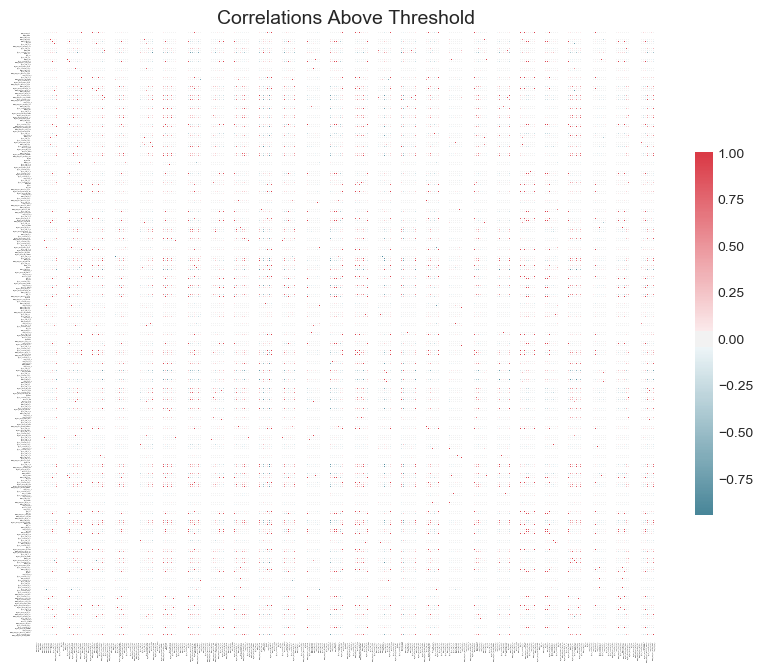

In [38]:
# highly correlated
fs.identify_collinear(correlation_threshold=0.75)
correlated_features = fs.ops['collinear']
fs.plot_collinear()

In [39]:
# Zero Importance Features
fs.identify_zero_importance(task = 'classification', eval_metric = 'auc_mu', 
                            n_iterations = 10, early_stopping = True)

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[194]	valid_0's auc_mu: 0.989579	valid_0's multi_logloss: 0.205293
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[167]	valid_0's auc_mu: 0.990631	valid_0's multi_logloss: 0.193021
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[221]	valid_0's auc_mu: 0.992476	valid_0's multi_logloss: 0.183675
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[220]	valid_0's auc_mu: 0.989903	valid_0's multi_logloss: 0.201708
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[149]	valid_0's auc_mu: 0.988967	valid_0's multi_logloss: 0.218535
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[191]	valid_0's auc_mu: 0.990746	valid_0's multi_

In [40]:
## one_hot_features
one_hot_features = fs.one_hot_features
base_features = fs.base_features
print('There are %d original features' % len(base_features))
print('There are %d one-hot features' % len(one_hot_features))

There are 438 original features
There are 0 one-hot features


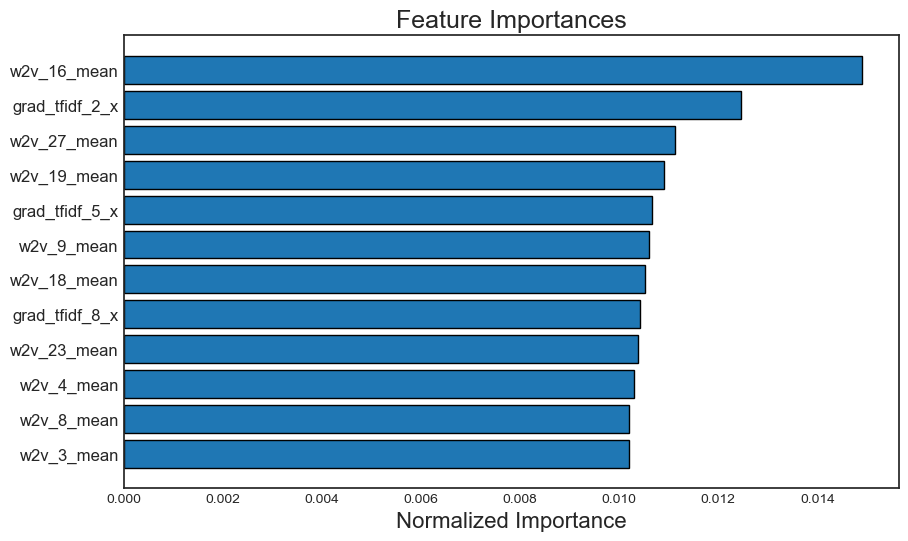

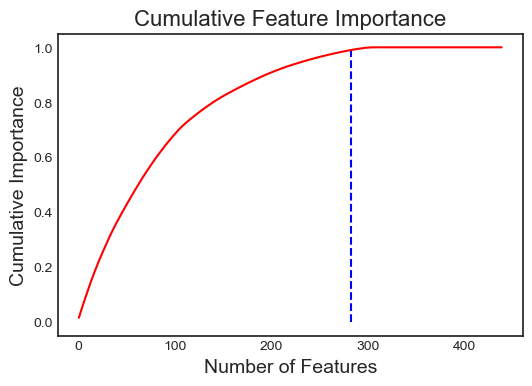

282 features required for 0.99 of cumulative importance


In [41]:
fs.plot_feature_importances(threshold = 0.99, plot_n = 12)

In [43]:
# Low Importance Features

fs.identify_low_importance(cumulative_importance = 0.99)
low_importance_features = fs.ops['low_importance']
low_importance_features[:5]

281 features required for cumulative importance of 0.99 after one hot encoding.
157 features do not contribute to cumulative importance of 0.99.



['speed_neq_zero_lat_q_20',
 'speed_neq_zero_lon_median',
 'lat_lon_countvec_4_x',
 'speed_q_30',
 'lat_q_30']

In [44]:
train_no_missing_zero = fs.remove(methods = ['missing', 'zero_importance'])

Removed 131 features.


In [47]:
all_to_remove = fs.check_removal()


Total of 329 features identified for removal


In [48]:
train_removed = fs.remove(methods = 'all')

['missing', 'single_unique', 'collinear', 'zero_importance', 'low_importance'] methods have been run

Removed 329 features.


In [51]:
train_removed_all = fs.remove(methods = 'all', keep_one_hot=False)


['missing', 'single_unique', 'collinear', 'zero_importance', 'low_importance'] methods have been run

Removed 329 features including one-hot features.


In [54]:
fs.identify_all(selection_params = {'missing_threshold': 0.6, 'correlation_threshold': 0.98, 
                                    'task': 'classification', 'eval_metric': 'auc_mu', 
                                     'cumulative_importance': 0.99})

0 features with greater than 0.60 missing values.

0 features with a single unique value.

206 features with a correlation magnitude greater than 0.98.

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[199]	valid_0's auc_mu: 0.991151	valid_0's multi_logloss: 0.188952
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[194]	valid_0's auc_mu: 0.992066	valid_0's multi_logloss: 0.17632
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[236]	valid_0's auc_mu: 0.99346	valid_0's multi_logloss: 0.157406
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[262]	valid_0's auc_mu: 0.992951	valid_0's multi_logloss: 0.169312
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[218]	valid_0's auc_mu: 0.99259	valid_0's multi_logloss: 0.170

In [55]:
train_removed_all_once = fs.remove(methods = 'all', keep_one_hot = True)

['missing', 'single_unique', 'collinear', 'zero_importance', 'low_importance'] methods have been run

Removed 219 features.


In [58]:
cols_list = train_removed_all_once.columns

## 贝叶斯优化

In [79]:
##############超参数优化的超参域###################
spaceParam = {
    'boosting': hp.choice('boosting',['gbdt','dart']),
    'learning_rate':hp.loguniform('learning_rate', np.log(0.01), np.log(0.05)),
    'num_leaves': hp.quniform('num_leaves', 3, 66, 3), 
    'feature_fraction': hp.uniform('feature_fraction', 0.7,1),
    'min_data_in_leaf': hp.quniform('min_data_in_leaf', 10, 50,5), 
    'num_boost_round':hp.quniform('num_boost_round',500,2000,100), 
    'bagging_fraction':hp.uniform('bagging_fraction',0.6,1)  
}
# 超参数优化 ---------------------------------------------------------------------------------
def getParam(param):
    for k in ['num_leaves', 'min_data_in_leaf','num_boost_round']:
        param[k] = int(float(param[k]))
    for k in ['learning_rate', 'feature_fraction','bagging_fraction']:
        param[k] = float(param[k])
    if param['boosting'] == 0:
        param['boosting'] = 'gbdt'
    elif param['boosting'] == 1:
#         param['boosting'] = 'dart'
        param['boosting'] = 'goss'
    # 添加固定参数
    param['objective'] = 'multiclass'
    param['max_depth'] = 7
    param['num_threads'] = 8
    param['is_unbalance'] = True
#     param['metric'] = 'None'
    param['metric'] = 'auc_mu'
    param['train_metric'] = True
    param['verbose'] = -1
    param['bagging_freq']=5
    param['num_class']=3 
    param['feature_pre_filter']=False
    return param
def f1_score_eval(preds, valid_df):
    labels = valid_df.get_label()
    preds = np.argmax(preds.reshape(3, -1), axis=0)
    scores = f1_score(y_true=labels, y_pred=preds, average='macro')
    return 'f1_score', scores, True
def lossFun(param):
    param = getParam(param)
    m = lgb.train(params=param,
                  train_set=train_data,
                  num_boost_round=param['num_boost_round'],
                  valid_sets=[train_data,valid_data],
                  valid_names=['train','valid'],
                  feature_name=features,
                  feval=f1_score_eval,
                  early_stopping_rounds=earlyStopping,
                  verbose_eval=False,
                  keep_training_booster=True)
    train_f1_score = m.best_score['train']['f1_score']
    valid_f1_score = m.best_score['valid']['f1_score']
    loss_f1_score = 1 - valid_f1_score
    print('训练集f1_score:{},测试集f1_score:{},loss_f1_score:{}'.format(train_f1_score, valid_f1_score, loss_f1_score))
    return {'loss': loss_f1_score, 'params': param, 'status': STATUS_OK}


In [82]:
use_train = all_df[all_df['label'] != -1][:200]
use_test = all_df[all_df['label'] == -1][:200]  #label为-1时是测试集
use_feats = [c for c in use_train.columns if c not in ['ID', 'label']]
X_train,X_verify,y_train,y_verify= train_test_split(use_train[use_feats],use_train['label'],test_size=0.3,random_state=0)

In [96]:
selectFeatures = 200 # 控制特征数
earlyStopping = 100 # 控制早停
select_num_boost_round = 1000 # 特征选择训练轮次
model_feature = use_feats
features = model_feature
train_data = lgb.Dataset(data=X_train[model_feature],label=y_train,feature_name=features)
valid_data = lgb.Dataset(data=X_verify[features],label=y_verify,reference=train_data,feature_name=features)

best_param = fmin(fn=lossFun, space=spaceParam, algo=tpe.suggest, max_evals=100, trials=Trials())
best_param = getParam(best_param)
print('Search best param:',best_param)

  0%|          | 0/100 [00:03<?, ?trial/s, best loss=?]


KeyboardInterrupt: 

In [97]:
def f1_score_eval(preds, valid_df):
    labels = valid_df.get_label()
    preds = np.argmax(preds.reshape(3, -1), axis=0)
    scores = f1_score(y_true=labels, y_pred=preds, average='macro')
    return 'f1_score', scores, True

def sub_on_line_lgb(train_, test_, pred, label, cate_cols, split,
                    is_shuffle=True,
                    use_cart=False,
                    get_prob=False):
    n_class = 3
    train_pred = np.zeros((train_.shape[0], n_class))
    test_pred = np.zeros((test_.shape[0], n_class))
    n_splits = 5

    assert split in ['kf', 'skf'
                    ], '{} Not Support this type of split way'.format(split)

    if split == 'kf':
        folds = KFold(n_splits=n_splits, shuffle=is_shuffle, random_state=1024)
        kf_way = folds.split(train_[pred])
    else:
        #与KFold最大的差异在于，他是分层采样，确保训练集，测试集中各类别样本的比例与原始数据集中相同。
        folds = StratifiedKFold(n_splits=n_splits,
                                shuffle=is_shuffle,
                                random_state=1024)
        kf_way = folds.split(train_[pred], train_[label])

    print('Use {} features ...'.format(len(pred)))
    #将以下参数改为贝叶斯优化之后的参数
    params = {
        'learning_rate': 0.05,
        'boosting_type': 'gbdt',
        'objective': 'multiclass',
        'metric': 'None',
        'num_leaves': 60,
        'feature_fraction':0.86,
        'bagging_fraction': 0.73,
        'bagging_freq': 5,
        'seed': 1,
        'bagging_seed': 1,
        'feature_fraction_seed': 7,
        'min_data_in_leaf': 15,
        'num_class': n_class,
        'nthread': 8,
        'verbose': -1,
        'num_boost_round': 1100,
        'max_depth': 7,
    }
    for n_fold, (train_idx, valid_idx) in enumerate(kf_way, start=1):
        print('the {} training start ...'.format(n_fold))
        train_x, train_y = train_[pred].iloc[train_idx
                                            ], train_[label].iloc[train_idx]
        valid_x, valid_y = train_[pred].iloc[valid_idx
                                            ], train_[label].iloc[valid_idx]

        if use_cart:
            dtrain = lgb.Dataset(train_x,
                                 label=train_y,
                                 categorical_feature=cate_cols)
            dvalid = lgb.Dataset(valid_x,
                                 label=valid_y,
                                 categorical_feature=cate_cols)
        else:
            dtrain = lgb.Dataset(train_x, label=train_y)
            dvalid = lgb.Dataset(valid_x, label=valid_y)

        clf = lgb.train(params=params,
                        train_set=dtrain,
#                         num_boost_round=3000,
                        valid_sets=[dvalid],
                        early_stopping_rounds=100,
                        verbose_eval=100,
                        feval=f1_score_eval)
        train_pred[valid_idx] = clf.predict(valid_x,
                                            num_iteration=clf.best_iteration)
        test_pred += clf.predict(test_[pred],
                                 num_iteration=clf.best_iteration) / folds.n_splits
    print(classification_report(train_[label], np.argmax(train_pred,
                                                         axis=1),
                                digits=4))
    if get_prob:
        sub_probs = ['qyxs_prob_{}'.format(q) for q in ['围网', '刺网', '拖网']]
        prob_df = pd.DataFrame(test_pred, columns=sub_probs)
        prob_df['ID'] = test_['ID'].values
        return prob_df
    else:
        test_['label'] = np.argmax(test_pred, axis=1)
        return test_[['ID', 'label']]

use_train = all_df[all_df['label'] != -1]
use_test = all_df[all_df['label'] == -1]
# use_feats = [c for c in use_train.columns if c not in ['ID', 'label']]
use_feats=model_feature
sub = sub_on_line_lgb(use_train, use_test, use_feats, 'label', [], 'kf',is_shuffle=True,use_cart=False,get_prob=False)

Use 438 features ...
the 1 training start ...
Training until validation scores don't improve for 100 rounds
[100]	valid_0's f1_score: 0.895266
[200]	valid_0's f1_score: 0.908359
[300]	valid_0's f1_score: 0.909259
Early stopping, best iteration is:
[281]	valid_0's f1_score: 0.913206
the 2 training start ...
Training until validation scores don't improve for 100 rounds
[100]	valid_0's f1_score: 0.906868
[200]	valid_0's f1_score: 0.916016
[300]	valid_0's f1_score: 0.920842
[400]	valid_0's f1_score: 0.926001
[500]	valid_0's f1_score: 0.923861
Early stopping, best iteration is:
[418]	valid_0's f1_score: 0.926637
the 3 training start ...
Training until validation scores don't improve for 100 rounds
[100]	valid_0's f1_score: 0.907465
[200]	valid_0's f1_score: 0.91502
[300]	valid_0's f1_score: 0.923048
[400]	valid_0's f1_score: 0.923328
Early stopping, best iteration is:
[308]	valid_0's f1_score: 0.926192
the 4 training start ...
Training until validation scores don't improve for 100 rounds
[1